In [1]:
from Neuron_analysis_tool.Analyzer import Analyzer, long_pulse_protocol
from Neuron_analysis_tool.utils import video_player
from pathlib import Path
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON mechanisms not found in /ems/elsc-labs/segev-i/yoni.leibner/PycharmProjects/Neuron_analysis_tool/Neuron_analysis_tool/x86_64/special.


NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


## Loading rall model

In [2]:
analyser = Analyzer(type='L5PC')

## plot the cell morphology

error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]


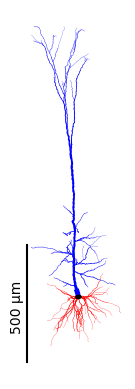

In [3]:
_,_,_ = analyser.plot_morph(scale=500, diam_factor=0.5, theta=-90, ignore_soma=True)

## create a somaticentric view card 

(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}, xlabel='distance from origin (x / λ)', ylabel='V(x)/V(0)'>,
        <AxesSubplot:title={'center':'short pulse attanuation'}, xlabel='distance from origin (x / λ)'>],
       dtype=object))

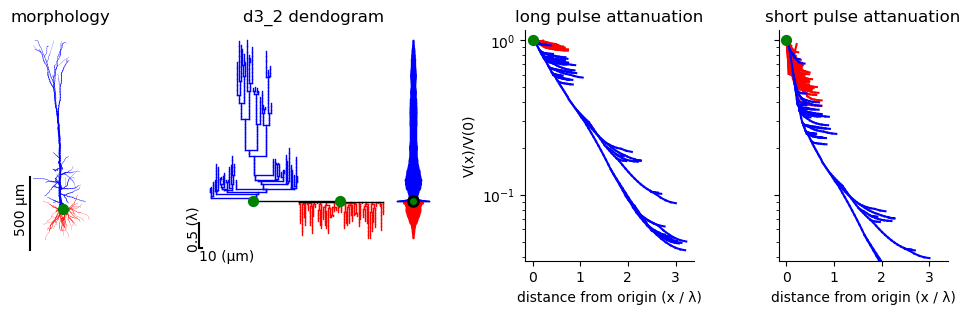

In [4]:
analyser.create_card(theta=-90, diam_factor=0.5, cable_factor=3)

## create a spasific segment centric view card

(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}, xlabel='distance from origin (x / λ)', ylabel='V(x)/V(0)'>,
        <AxesSubplot:title={'center':'short pulse attanuation'}, xlabel='distance from origin (x / λ)'>],
       dtype=object))

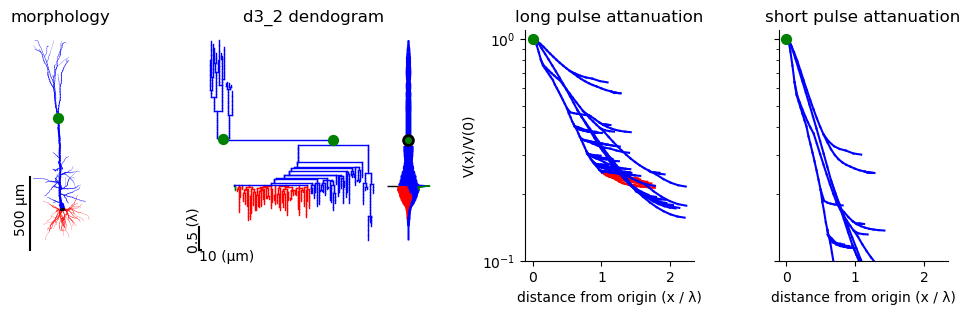

In [5]:
analyser.create_card(start_seg=list(analyser.cell.apic[50])[-1], theta=-90, diam_factor=0.5, cable_factor=3)

(<Figure size 1200x300 with 3 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'dendogram'}>,
        <AxesSubplot:title={'center':'$d^{3/2}$ equivalent cable'}, xlabel='diameter (μm)', ylabel='distance (λ)'>],
       dtype=object))

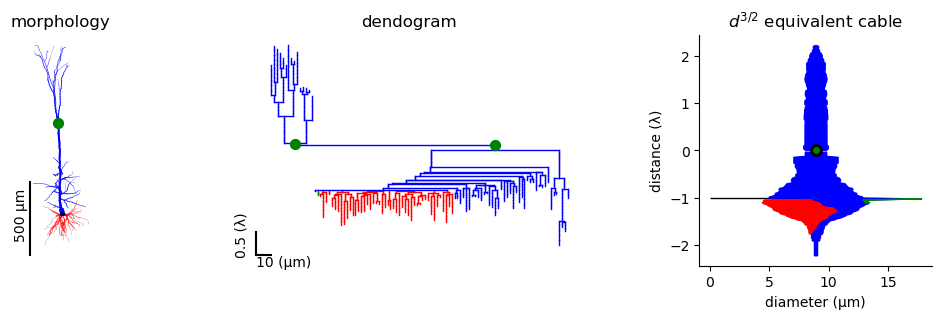

In [6]:
analyser.create_morpho_card(start_seg=list(analyser.cell.apic[50])[-1], theta=-90, diam_factor=0.5)

## defining a new protocol to record, protocol is a function that gets the cell and the start segment (in the case you intrested of using a spasific one), and runs a simulation.
### the function muyst return the tstop of the simulation, the delay/time to start, the duration of the activation, the amplitude, and a dictionary with extra stuff you want to save for to the end of the computation of this video

In [4]:
def Ca_spike_protocol(cell, start_seg):
    delay=400.0
    stim = h.IClamp(0.5, sec=cell.soma[0])
    stim.dur   = 5
    stim.delay = delay

    syn = h.epsp(cell.apic[36](0.9))
    syn.tau0  = 0.5
    syn.tau1 = 5
    syn.onset   = stim.delay + 5
    syn.imax = 0.5 
    stim.amp = 1.9
    
    h.tstop = 550
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    h.run()
    return 400, {}

In [5]:
records, extra = analyser.record_protocol(protocol=Ca_spike_protocol, record_names=['v', 'gCa_LVAst_Ca_LVAst'], compute_more_condunctances=True)


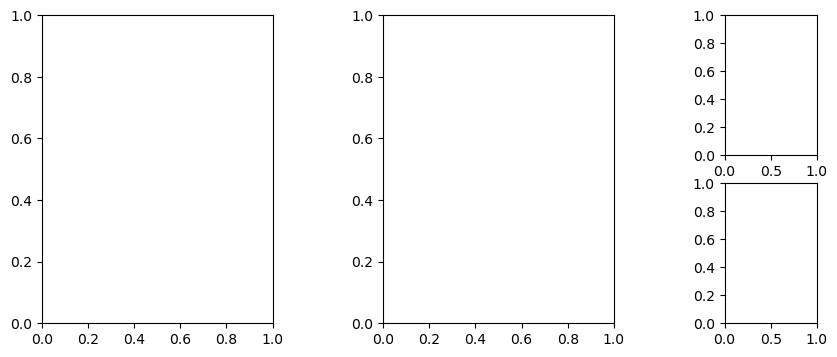

In [10]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize=(10, 4))
plt.tight_layout()
gs = GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.4])
ax_morph = fig.add_subplot(gs[:, 0])
ax_morph2 = fig.add_subplot(gs[:, 1])
ax_soma_voltage = fig.add_subplot(gs[1, 2])
ax_hot_spot_voltage = fig.add_subplot(gs[0, 2])
f = lambda: plt.subplots_adjust(wspace=0.6)
f()

seg_to_indicate_dict = dict()
seg_to_indicate_dict[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
seg_to_indicate_dict[list(analyser.cell.apic[36])[-1]] = dict(label='tip', alpha=0.75, color='grey', size=50)

soma_seg = list(analyser.cell.soma[0])[0]
plot_kwargs = [
    dict(ax=ax_morph, seg = soma_seg, records=records.all_records['v'], electrical=False, plot_type='morph', seg_to_indicate_dict=seg_to_indicate_dict,plot_color_bar=True, theta=270, scale=500),
    dict(ax=ax_morph2, seg = soma_seg, records=records.all_records['gCa_LVAst_Ca_LVAst'], electrical=False, plot_type='morph', seg_to_indicate_dict=seg_to_indicate_dict,plot_color_bar=True, theta=270, scale=500),
    dict(ax=ax_soma_voltage, seg = soma_seg, records=records.all_records['v'], plot_type='single_record', color='lime'),
    dict(ax=ax_hot_spot_voltage, seg = list(analyser.cell.apic[36])[-1], records=records.all_records['v'], plot_type='single_record', color='grey'),
    
              ]
f = lambda: plt.tight_layout()
slow_down_factor=50
videos_folder = 'videos/L5PC/'
video_name = 'voltage_and_gCa_LVAst_on_morph.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, func_before_run=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)


duration= 15.000000000003633
Moviepy - Building video videos/L5PC/dancing_morph_and_dendogram.mp4.
Moviepy - Writing video videos/L5PC/dancing_morph_and_dendogram.mp4



Moviepy - Done !
Moviepy - video ready videos/L5PC/dancing_morph_and_dendogram.mp4


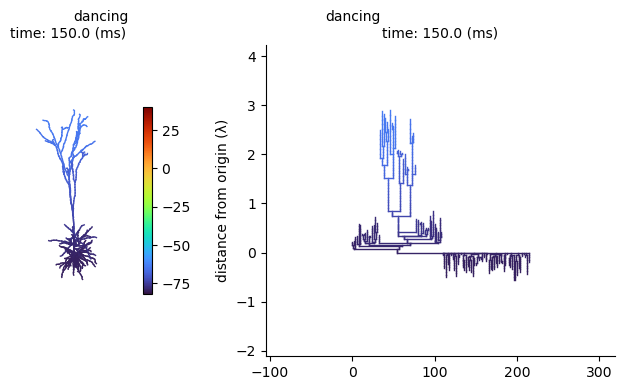

In [11]:
more_conductances_ = extra['more_conductances']

fig, ax = plt.subplots(1,2, figsize=(8,4))
soma_seg = list(analyser.cell.soma[0])[0]

plot_kwargs = [
    dict(ax=ax[0], seg = soma_seg, records=records.all_records['v'], electrical=True, plot_type='morph',
         plot_color_bar=True, theta=270, dancing=True, more_conductances_=more_conductances_),
    dict(ax=ax[1], seg = soma_seg, records=records.all_records['v'], electrical=True, plot_type='dendogram', 
         plot_color_bar=False, dancing=True, more_conductances_=more_conductances_),
#     dict(ax=ax[2], seg = soma_seg, plot_type='cable', cable_type='d3_2',
#          factor_e_space=25, records=records.all_records['v'], more_conductances_=more_conductances_, scales=dict(x=10, y=2)),
              ]
f = lambda: plt.tight_layout()
slow_down_factor=100
videos_folder = 'videos/L5PC/'
video_name = 'dancing_morph_and_dendogram.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, func_before_run=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

# animation = analyser.create_movie_from_rec(fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs)
# animation.ipython_display(fps=10, loop=True, autoplay=True, maxduration=animation.duration+10)

duration= 7.500000000001816
Moviepy - Building video videos/L5PC/spiking_morph_dendogram_and_attenuation.mp4.
Moviepy - Writing video videos/L5PC/spiking_morph_dendogram_and_attenuation.mp4



Moviepy - Done !
Moviepy - video ready videos/L5PC/spiking_morph_dendogram_and_attenuation.mp4


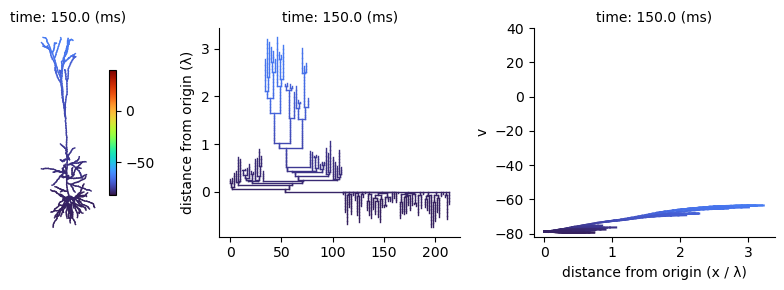

In [6]:
fig, ax = plt.subplots(1,3, figsize=(9, 3))
plt.tight_layout()
soma_seg = list(analyser.cell.soma[0])[0]

plot_kwargs = [
    dict(ax=ax[0], seg = soma_seg, records=records.all_records['v'], electrical=False, plot_type='morph',plot_color_bar=True, theta=270),
    dict(ax=ax[1], seg = soma_seg, records=records.all_records['v'], electrical=True, plot_type='dendogram', plot_color_bar=False),
    dict(ax=ax[2], seg = soma_seg, records=records.all_records['v'], electrical=True, plot_type='attenuation'),
              ]
f = lambda: plt.tight_layout()
slow_down_factor=50
videos_folder = 'videos/L5PC/'
video_name = 'spiking_morph_dendogram_and_attenuation.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, func_before_run=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

# animation = analyser.create_movie_from_rec(fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs)
# animation.ipython_display(fps=10, loop=True, autoplay=True, maxduration=animation.duration+10)

### the morphology, dendogram and cable can dance
#### in order to do this you need to make sure to set compute_more_condunctances=True above at the record_protocol function

duration= 15.000000000003633
Moviepy - Building video videos/L5PC/dancing_morph_and_dendogram.mp4.
Moviepy - Writing video videos/L5PC/dancing_morph_and_dendogram.mp4



Moviepy - Done !
Moviepy - video ready videos/L5PC/dancing_morph_and_dendogram.mp4


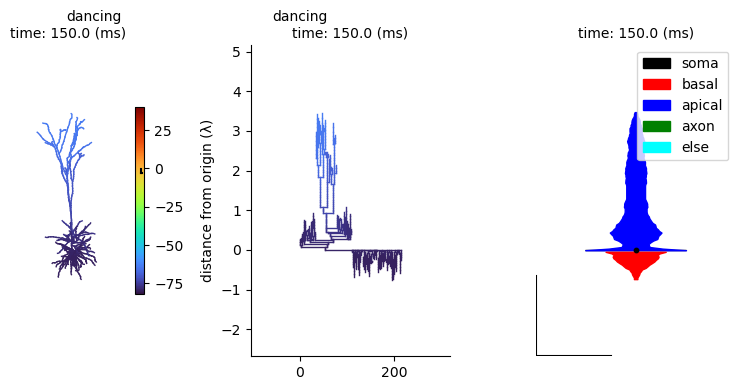

In [7]:
more_conductances_ = extra['more_conductances']

fig, ax = plt.subplots(1,3, figsize=(8,4))
soma_seg = list(analyser.cell.soma[0])[0]

plot_kwargs = [
    dict(ax=ax[0], seg = soma_seg, records=records.all_records['v'], electrical=True, plot_type='morph',
         plot_color_bar=True, theta=270, dancing=True, more_conductances_=more_conductances_),
    dict(ax=ax[1], seg = soma_seg, records=records.all_records['v'], electrical=True, plot_type='dendogram', 
         plot_color_bar=False, dancing=True, more_conductances_=more_conductances_),
    dict(ax=ax[2], seg = soma_seg, plot_type='cable', cable_type='d3_2',
         factor_e_space=25, records=records.all_records['v'], more_conductances_=more_conductances_, scales=dict(x=10, y=2)),
              ]
f = lambda: plt.tight_layout()
slow_down_factor=100
videos_folder = 'videos/L5PC/'
video_name = 'dancing_morph_and_dendogram.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, func_before_run=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

# animation = analyser.create_movie_from_rec(fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs)
# animation.ipython_display(fps=10, loop=True, autoplay=True, maxduration=animation.duration+10)

### we can also show other king of recording on the same video
#### in order to do this you need to record multipule values in the record_protocol function above, here we show voltage and gCa_LVAst_Ca_LVAst

duration= 7.500000000001816
Moviepy - Building video videos/L5PC/voltage_and_gCa_LVAst_on_morph.mp4.
Moviepy - Writing video videos/L5PC/voltage_and_gCa_LVAst_on_morph.mp4



Moviepy - Done !
Moviepy - video ready videos/L5PC/voltage_and_gCa_LVAst_on_morph.mp4


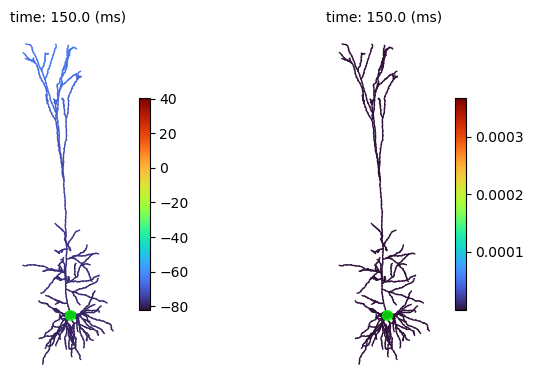

In [8]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
soma_seg = list(analyser.cell.soma[0])[0]
hot_spot_seg = list(analyser.cell.apic[36])[0]
seg_to_indicate_dict = dict()
seg_to_indicate_dict[soma_seg] = dict(label='soma', alpha=0.75, color='lime', size=50)

plot_kwargs = [
    dict(ax=ax[0], seg = soma_seg, records=records.all_records['v'], electrical=False, plot_type='morph', seg_to_indicate_dict=seg_to_indicate_dict,plot_color_bar=True, theta=270),
    dict(ax=ax[1], seg = soma_seg, records=records.all_records['gCa_LVAst_Ca_LVAst'], electrical=False, plot_type='morph', seg_to_indicate_dict=seg_to_indicate_dict,plot_color_bar=True, theta=270),
              ]
f = lambda: plt.tight_layout()
slow_down_factor=50
videos_folder = 'videos/L5PC/'
video_name = 'voltage_and_gCa_LVAst_on_morph.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, func_before_run=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

# animation = analyser.create_movie_from_rec(fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs)
# animation.ipython_display(fps=10, loop=True, autoplay=True, maxduration=animation.duration+10)

### we can also show other king of recording on the same video
#### in order to do this you need to record multipule values in the record_protocol function above, here we show voltage and gCa_LVAst_Ca_LVAst

In [3]:
def Ca_spike_protocol2(cell, start_seg):
    delay=400.0
    stim = h.IClamp(0.5, sec=cell.soma[0])
    stim.dur   = 5
    stim.delay = delay

    syn = h.epsp(cell.apic[36](0.9))
    syn.tau0  = 0.5
    syn.tau1 = 5
    syn.onset   = stim.delay + 5
    syn.imax = 0.5 
    stim.amp = 1.9
    
    h.tstop = 450
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    h.run()
    return 400, {}

In [4]:
records2, extra2 = analyser.record_protocol(protocol=Ca_spike_protocol2, record_names=['v', 'gCa_LVAst_Ca_LVAst'], compute_more_condunctances=True)


duration= 19.99999999998181


t:   8%|████████████▏                                                                                                                                               | 47/601 [01:34<11:27,  1.24s/it, now=None]

Moviepy - Building video videos/L5PC/dancing_morph_and_dendogram_slow.mp4.
Moviepy - Writing video videos/L5PC/dancing_morph_and_dendogram_slow.mp4




t:  38%|███████████████████████████████████████████████████████████▎                                                                                                | 76/200 [01:18<02:09,  1.05s/it, now=None]


t:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 152/200 [02:39<00:50,  1.05s/it, now=None]


t:   8%|████████████▏                                                                                                                                               | 47/601 [05:04<11:27,  1.24s/it, now=None]

Moviepy - Done !
Moviepy - video ready videos/L5PC/dancing_morph_and_dendogram_slow.mp4


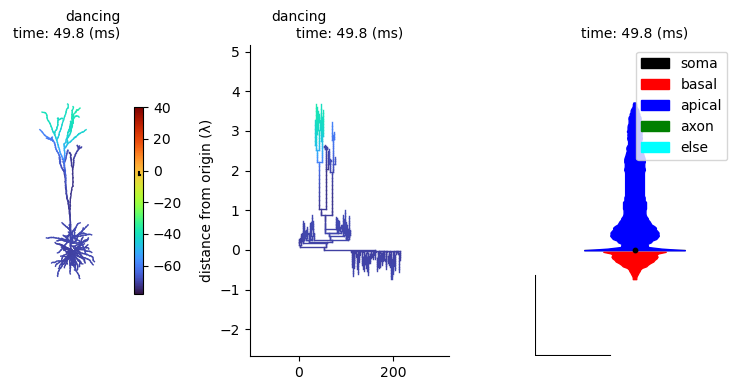

In [13]:
more_conductances_ = extra2['more_conductances']

fig, ax = plt.subplots(1,3, figsize=(8,4))
soma_seg = list(analyser.cell.soma[0])[0]

plot_kwargs = [
    dict(ax=ax[0], seg = soma_seg, records=records2.all_records['v'], electrical=True, plot_type='morph',
         plot_color_bar=True, theta=270, dancing=True, more_conductances_=more_conductances_),
    dict(ax=ax[1], seg = soma_seg, records=records2.all_records['v'], electrical=True, plot_type='dendogram', 
         plot_color_bar=False, dancing=True, more_conductances_=more_conductances_),
    dict(ax=ax[2], seg = soma_seg, plot_type='cable', cable_type='d3_2',
         factor_e_space=25, records=records.all_records['v'], more_conductances_=more_conductances_, scales=dict(x=10, y=2)),
              ]
f = lambda: plt.tight_layout()
slow_down_factor=400
videos_folder = 'videos/L5PC/'
video_name = 'dancing_morph_and_dendogram_slow.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, f=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

# animation = analyser.create_movie_from_rec(fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs)
# animation.ipython_display(fps=10, loop=True, autoplay=True, maxduration=animation.duration+10)

duration= 49.999999999954525


t:   8%|████████████▏                                                                                                                                               | 47/601 [09:58<11:27,  1.24s/it, now=None]

Moviepy - Building video videos/L5PC/dancing_morph_and_dendogram_very_slow.mp4.
Moviepy - Writing video videos/L5PC/dancing_morph_and_dendogram_very_slow.mp4




t:  15%|███████████████████████▋                                                                                                                                    | 76/500 [01:20<07:48,  1.11s/it, now=None]


t:  30%|███████████████████████████████████████████████                                                                                                            | 152/500 [02:40<06:04,  1.05s/it, now=None]


t:  46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 228/500 [04:01<04:41,  1.04s/it, now=None]


t:  61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 304/500 [05:22<03:21,  1.03s/it, now=None]


t:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 380/500 [06:43<02:10,  1.08s/it, now=None]


t:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 456/500 [08:03<00:46,  1.05s/it, now=None]


t:   8%|████████████▏                                                                                                                                               | 47/601 [18:47<11:27,  1.24s/it, now=None]

Moviepy - Done !
Moviepy - video ready videos/L5PC/dancing_morph_and_dendogram_very_slow.mp4


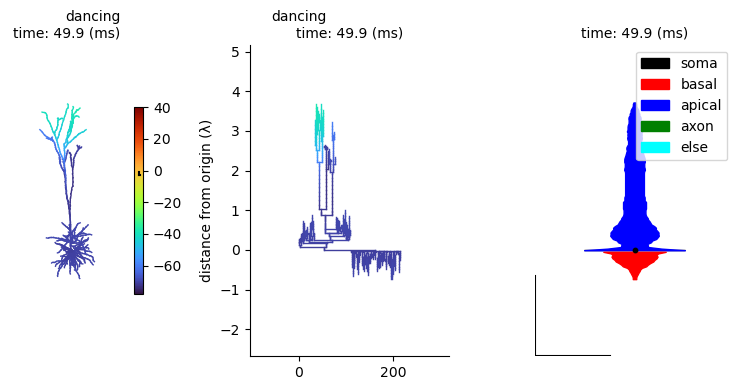

	-70.787817 


In [14]:
more_conductances_ = extra2['more_conductances']

fig, ax = plt.subplots(1,3, figsize=(8,4))
soma_seg = list(analyser.cell.soma[0])[0]

plot_kwargs = [
    dict(ax=ax[0], seg = soma_seg, records=records2.all_records['v'], electrical=True, plot_type='morph',
         plot_color_bar=True, theta=270, dancing=True, more_conductances_=more_conductances_),
    dict(ax=ax[1], seg = soma_seg, records=records2.all_records['v'], electrical=True, plot_type='dendogram', 
         plot_color_bar=False, dancing=True, more_conductances_=more_conductances_),
    dict(ax=ax[2], seg = soma_seg, plot_type='cable', cable_type='d3_2',
         factor_e_space=25, records=records.all_records['v'], more_conductances_=more_conductances_, scales=dict(x=10, y=2)),
              ]
f = lambda: plt.tight_layout()
slow_down_factor=1000
videos_folder = 'videos/L5PC/'
video_name = 'dancing_morph_and_dendogram_very_slow.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, f=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

# animation = analyser.create_movie_from_rec(fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs)
# animation.ipython_display(fps=10, loop=True, autoplay=True, maxduration=animation.duration+10)

duration= 49.999999999954525
Moviepy - Building video videos/L5PC/cable_check2.mp4.
Moviepy - Writing video videos/L5PC/cable_check2.mp4



Moviepy - Done !
Moviepy - video ready videos/L5PC/cable_check2.mp4


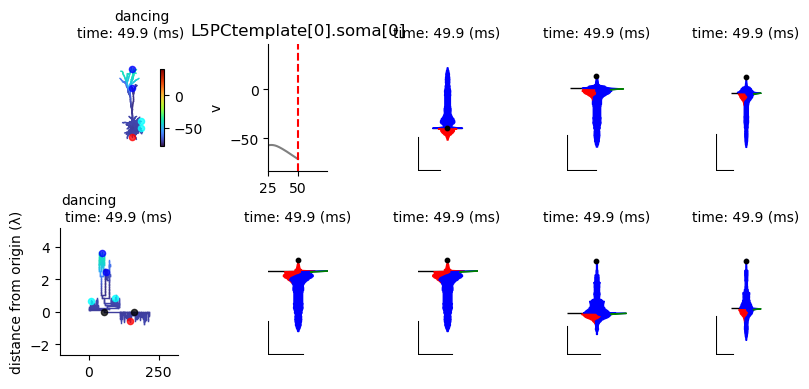

In [11]:
more_conductances_ = extra2['more_conductances']


fig, ax = plt.subplots(2,5, figsize=(8,4), gridspec_kw={'width_ratios': [1, 0.5,0.5,0.5, 0.5]})
soma_seg = list(analyser.cell.soma[0])[0]
basal_tip1 = list(analyser.cell.dend[28])[-1]
basal_tip2 = list(analyser.cell.dend[28])[-1]

oblique_tip1 = list(analyser.cell.apic[102])[-1]
oblique_tip2 = list(analyser.cell.apic[19])[-1]
tuft_tip1 = list(analyser.cell.apic[67])[-1]
tuft_tip2 = list(analyser.cell.apic[52])[-1]

seg_to_indicate_dict = dict()
seg_to_indicate_dict[soma_seg] = dict(label='soma', alpha=0.75, color='k', size=20)
seg_to_indicate_dict[basal_tip1] = dict(label='basal', alpha=0.75, color='r', size=20)
seg_to_indicate_dict[basal_tip2] = dict(label='basal', alpha=0.75, color='r', size=20)

seg_to_indicate_dict[oblique_tip1] = dict(label='oblique', alpha=0.75, color='cyan', size=20)
seg_to_indicate_dict[oblique_tip2] = dict(label='oblique', alpha=0.75, color='cyan', size=20)
seg_to_indicate_dict[tuft_tip1] = dict(label='tuft', alpha=0.75, color='b', size=20)
seg_to_indicate_dict[tuft_tip2] = dict(label='tuft', alpha=0.75, color='b', size=20)


plot_kwargs = [
    dict(ax=ax[0, 0], seg = soma_seg, records=records2.all_records['v'], electrical=True, plot_type='morph',
         plot_color_bar=True, theta=270, dancing=True, more_conductances_=more_conductances_, seg_to_indicate_dict=seg_to_indicate_dict,),
    dict(ax=ax[1, 0], seg = soma_seg, records=records2.all_records['v'], electrical=True, plot_type='dendogram', 
         plot_color_bar=False, dancing=True, more_conductances_=more_conductances_, seg_to_indicate_dict=seg_to_indicate_dict,),
    dict(ax=ax[0, 1], seg = soma_seg, records=records2.all_records['v'], plot_type='single_record', color='grey'),
    
    dict(ax=ax[0, 2], seg = soma_seg, plot_type='cable', cable_type='d3_2', shift=0,
         factor_e_space=25, more_conductances_=more_conductances_, 
         scales=dict(x=10, y=2), plot_legend=False),
    
    dict(ax=ax[1,1], seg = basal_tip1, plot_type='cable', cable_type='d3_2', shift=0,
         factor_e_space=25, more_conductances_=more_conductances_, 
         scales=dict(x=10, y=2), plot_legend=False),
    
    dict(ax=ax[1,2], seg = basal_tip2, plot_type='cable', cable_type='d3_2', shift=0,
         factor_e_space=25, more_conductances_=more_conductances_, 
         scales=dict(x=10, y=2), plot_legend=False),
    
    dict(ax=ax[0, 3], seg = oblique_tip1, plot_type='cable', cable_type='d3_2', shift=0,
         factor_e_space=25, more_conductances_=more_conductances_, 
         scales=dict(x=10, y=2), plot_legend=False),
    
    dict(ax=ax[0, 4], seg = oblique_tip2, plot_type='cable', cable_type='d3_2', shift=0,
         factor_e_space=25, more_conductances_=more_conductances_, 
         scales=dict(x=10, y=2), plot_legend=False),
    
    dict(ax=ax[1,3], seg = tuft_tip1, plot_type='cable', cable_type='d3_2', shift=0,
         factor_e_space=25, more_conductances_=more_conductances_, 
         scales=dict(x=10, y=2), plot_legend=False),
    
    dict(ax=ax[1,4], seg = tuft_tip2, plot_type='cable', cable_type='d3_2', shift=0,
         factor_e_space=25, more_conductances_=more_conductances_, 
         scales=dict(x=10, y=2), plot_legend=False),
    
              ]
f = lambda: plt.tight_layout()
slow_down_factor=1000
videos_folder = 'videos/L5PC/'
video_name = 'cable_check2.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, f=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

# animation = analyser.create_movie_from_rec(fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs)
# animation.ipython_display(fps=10, loop=True, autoplay=True, maxduration=animation.duration+10)

In [7]:
# more_conductances_ = extra2['more_conductances']

# fig, ax = plt.subplots(1,3, figsize=(8,4))
# soma_seg = list(analyser.cell.soma[0])[0]
# basal_tip = list(analyser.cell.dend[28])[-1]

# plot_kwargs = [
#     dict(ax=ax[0], seg = soma_seg, records=records2.all_records['v'], electrical=True, plot_type='morph',
#          plot_color_bar=True, theta=270, dancing=True, more_conductances_=more_conductances_),
#     dict(ax=ax[1], seg = basal_tip, records=records2.all_records['v'], electrical=True, plot_type='dendogram', 
#          plot_color_bar=False, dancing=True, more_conductances_=more_conductances_),
#     dict(ax=ax[2], seg = basal_tip, plot_type='cable', cable_type='d3_2', shift=0, 
#          factor_e_space=25, more_conductances_=more_conductances_, scales=None, plot_legend=False),
#               ]
# f = lambda: plt.tight_layout()
slow_down_factor=100
videos_folder = 'videos/L5PC/'
video_name = 'dancing_morph_and_dendogram2.mp4'
os.makedirs(videos_folder, exist_ok=True)
# analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, f=[f],
#                              save_to=videos_folder, clip_name=video_name, fps=10, 
#                              threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

# animation = analyser.create_movie_from_rec(fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs)
# animation.ipython_display(fps=10, loop=True, autoplay=True, maxduration=animation.duration+10)

In [ ]:
from Neuron_analysis_tool.Analyzer import Analyzer
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt
from Neuron_analysis_tool.distance import Distance
from Neuron_analysis_tool.Video import plot_all_records_func

In [ ]:
analyser = Analyzer(type='L5PC')

In [3]:
def add_syn(seg, g_AMPA=0.0004, g_NMDA=0.0004):
    delay=200.0
    netstim = h.NetStim()
    netstim.interval = 1 # fr of 1
    netstim.start = delay
    netstim.noise = 0.0
    netstim.number = 1
    # AMPA part
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con= h.NetCon(netstim, AMPA)
    AMPA.e = 0
    AMPA.tau1 = 0.3
    AMPA.tau2 = 3
    AMPA_con.weight[0] = g_AMPA
    AMPA_con.delay = 0

    # NMDA part
    NMDA=h.NMDA(seg.x, sec=seg.sec)
    NMDA_con = h.NetCon(netstim, NMDA)
    NMDA.e = 0
    NMDA.tau_r_NMDA = 2
    NMDA.tau_d_NMDA = 70
    NMDA.n_NMDA = 0.27
    NMDA.gama_NMDA = 0.076
    NMDA_con.weight[0] = g_NMDA
    NMDA_con.delay = 0
    return [AMPA, AMPA_con], [NMDA, NMDA_con], netstim

def multi_synapse_spike_protocol(cell, start_seg):
    syns = []
    for sec in cell.all:
        if sec in cell.soma or sec in cell.axon:
            continue
        for seg in sec:
            syns.append(add_syn(seg))
    print(len(syns))
    h.tstop = 600
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    h.run()
    return 0, {}

In [4]:
records, extra = analyser.record_protocol(protocol=multi_synapse_spike_protocol, record_names=['v'])


727


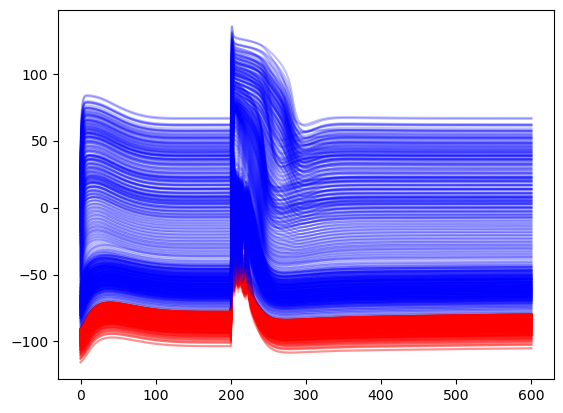

In [22]:

distance = Distance(analyser.cell, analyser.more_conductances)
soma_seg = list(analyser.cell.soma[0])[0]
distance.compute(soma_seg)
fig, ax = plt.subplots(1)
plot_all_records_func(records.all_records['v'], distance, ax, analyser, distance_factor=50, 
                      plot_every=0.01, alpha=0.25)

Text(0.5, 1.0, 'electrical distance')

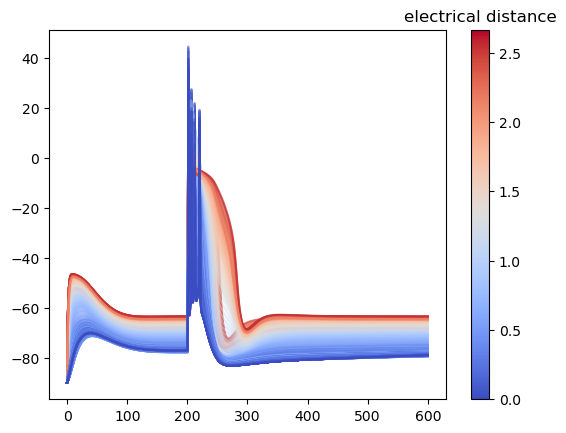

In [24]:

from Neuron_analysis_tool.distance import Distance
dist = Distance(analyser.cell, analyser.more_conductances)
soma_seg = list(analyser.cell.soma[0])[0]
dist.compute(soma_seg)
import matplotlib as mpl
max_dist = dist.get_max()
norm = mpl.colors.Normalize(vmin=0, vmax=max(max_dist.values()))
cmap=plt.cm.coolwarm
factor=0
fig, ax = plt.subplots(1)
for sec in records.all_records['v'].record_dict.keys():
    for seg in records.all_records['v'].record_dict[sec].keys():
        electrical_distance = dist.get_mid_point_str(sec, seg, electrical=True) 
        color = cmap(norm(electrical_distance))
        ax.plot(records.all_records['v'].time, 
                 records.all_records['v'].record_dict[sec][seg]._record+electrical_distance*factor,
                alpha=0.5, color=color)

im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
color_bar = plt.colorbar(im, ax=ax)
cax = color_bar.ax
fig.add_axes(cax)
cax.set_title('electrical distance')
        